# for optimisation

In [3]:
import scanpy as sc
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np
import glob

In [4]:
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=150, figsize = [7, 7], fontsize = 14, format = 'svg')

In [5]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

Need these GEO submissions:
```
GSM5343851 	HYR__1ec4a0__20200929_Exo_S1
GSM5343852 	HYR__3ac717__20201006_non-exo_S2
GSM5343853 	HYR__70afb2__20201006_TSO-LNA_S3
GSM5343854 	HYR__c6c4b7__20201016_gtp_S4
GSM5343855 	HYR__d0a5b4__20201023_klenow_S5
GSM5343856 	HYR__f0eb5a__20201023_bst_S6
```

In [1]:
import glob as glob
for sample in sorted(glob.glob('mtx_optim2/*/*/filtered/')):
    print(sample)

mtx_optim2/HYR__1ec4a0__20200929_Exo_S1.Solo.out/Gene/filtered/
mtx_optim2/HYR__3ac717__20201006_non-exo_S2.Solo.out/Gene/filtered/
mtx_optim2/HYR__70afb2__20201006_TSO-LNA_S3.Solo.out/Gene/filtered/
mtx_optim2/HYR__c6c4b7__20201016_smart-seq3_S4.Solo.out/Gene/filtered/
mtx_optim2/HYR__d0a5b4__20201023_klenow_S5.Solo.out/Gene/filtered/
mtx_optim2/HYR__f0eb5a__20201023_bst_S6.Solo.out/Gene/filtered/


In [2]:
legend = {
'mtx_optim/HYR__1ec4a0__20200929_Exo_S1.Solo.out/Gene/raw/': 'Exo+',
'mtx_optim/HYR__3ac717__20201006_non-exo_S2.Solo.out/Gene/raw/': 'Exo-',
'mtx_optim/HYR__70afb2__20201006_TSO-LNA_S3.Solo.out/Gene/raw/': 'TSO-LNA',
'mtx_optim/HYR__c6c4b7__20201016_smart-seq3_S4.Solo.out/Gene/raw/': 'GTP/Glycerol',
'mtx_optim/HYR__d0a5b4__20201023_klenow_S5.Solo.out/Gene/raw/': 'Klenow',
'mtx_optim/HYR__f0eb5a__20201023_bst_S6.Solo.out/Gene/raw/': 'Bst2.0'
}



In [18]:
legend = {
'mtx_optim/HYR__1ec4a0__20200929_Exo_S1.Solo.out/Gene/filtered/': 'Exo+',
'mtx_optim/HYR__3ac717__20201006_non-exo_S2.Solo.out/Gene/filtered/': 'Exo-',
'mtx_optim/HYR__70afb2__20201006_TSO-LNA_S3.Solo.out/Gene/filtered/': 'TSO-LNA',
'mtx_optim/HYR__c6c4b7__20201016_smart-seq3_S4.Solo.out/Gene/filtered/': 'GTP-Glycerol',
'mtx_optim/HYR__d0a5b4__20201023_klenow_S5.Solo.out/Gene/filtered/': 'Klenow',
'mtx_optim/HYR__f0eb5a__20201023_bst_S6.Solo.out/Gene/filtered/': 'Bst2.0'
}



In [19]:
markersize = 10

KeyError: 'mtx_optim/HYR__1ec4a0__20200929_Exo_S1.Solo.out/Gene/raw/'

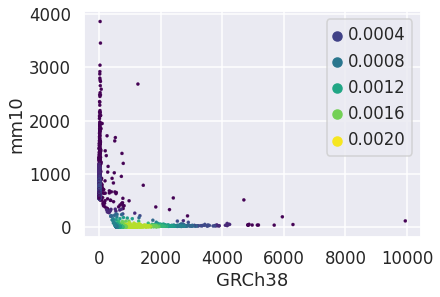

In [20]:
top_n = 2000
for sample in sorted(glob.glob('mtx_optim/*/*/raw/')):
    mtx = sample + 'matrix.mtx'
    features = sample + 'features.tsv'
    barcodes = sample + 'barcodes.tsv'
    data = sc.read_mtx(mtx)
    data = data.T
    features = pd.read_csv(features, header=None, sep='\t')
    barcodes = pd.read_csv(barcodes, header=None)
    data.var_names = features[0]
    data.obs_names = barcodes[0]

    adata = data
    adata.var_names_make_unique()

    ## then, generate barnyard plots, but now from matrix
    # get variables list from adata
    adata_vars = list(adata.var.index.values)
    adata_obs = list(adata.obs.index.values)

    # list gene names from each genome
    adata_vars_GRCh38 = [x for x in adata_vars if x.startswith('ENSG') or x.startswith('GRCh38')]
    adata_vars_mm10 = [x for x in adata_vars if x.startswith('ENSMUS') or x.startswith('mm10')]

    # then, select from adata the values corresponding to each gene
    adata_GRCh38 = adata[:, adata_vars_GRCh38]
    adata_mm10 = adata[:, adata_vars_mm10]

    # then, colsum in order to collapse counts for each genome
    adata_GRCh38_colsum = adata_GRCh38.X.sum(axis=1)
    adata_mm10_colsum = adata_mm10.X.sum(axis=1)

    # convert to df
    df_adata_GRCh38_colsum = pd.DataFrame(adata_GRCh38_colsum, index = adata_obs, columns = ['GRCh38'])
    df_adata_mm10_colsum = pd.DataFrame(adata_mm10_colsum, index = adata_obs, columns = ['mm10'])

    # merge
    df_adata_colsum = pd.concat([df_adata_GRCh38_colsum, df_adata_mm10_colsum], axis=1, sort=False)

    # add rowsum
    df_adata_colsum['sum'] = df_adata_colsum.sum(axis=1)

    # now sort on rowsum
    df_adata_colsum_sorted = df_adata_colsum.sort_values(by = 'sum', axis = 0, ascending = False)

    sns.set_style('darkgrid')
    sns.set_context('talk')
    ddmarkersize=25
    nbins = 10
    # now replace zeros by 1s for the log scale
    df_adata_colsum_nozeros = df_adata_colsum_sorted.mask(df_adata_colsum_sorted == 0, 1)
    df_adata_colsum_nozeros_sorted = df_adata_colsum_nozeros.sort_values(by = 'sum', axis = 0, ascending = False)

    ## now plot the barnyard for the top n cells 
    df_adata_colsum_nozeros_sorted_top_n = df_adata_colsum_nozeros_sorted[0:top_n]
    # df_adata_colsum_nozeros_sorted_top_n = df_adata_colsum_nozeros_sorted
    
    x = df_adata_colsum_nozeros_sorted_top_n['GRCh38']
    y = df_adata_colsum_nozeros_sorted_top_n['mm10']

    xy = np.vstack([np.log10(x),y])
    z = gaussian_kde(xy)(xy)
    bins = np.linspace(z.min(), z.max(), nbins)
    digitized = np.digitize(z, bins)
    bin_means = [z[digitized == i].mean() for i in range(1, len(bins))]
    digitized_rescaled = np.interp(digitized, (digitized.min(), digitized.max()), (z.min(), z.max()))

    ax = sns.scatterplot(x = 'GRCh38', y = 'mm10', data = df_adata_colsum_nozeros_sorted_top_n, hue = digitized_rescaled, palette='viridis', edgecolor=None, s=markersize)

    # sns.kdeplot(x = x, y = y, shade=False, log_scale=True, levels=5, cbar=False, bw_method=0.1, ax=axes[1])
    ax.set_title(legend[sample])
    scalemax = max([max(x), max(y)])
    scalemin = -0.05*max([max(x), max(y)])
    ax.set_xlim([scalemin, scalemax])
    ax.set_ylim([scalemin, scalemax])
    ax.set(xscale='linear')
    ax.set(yscale='linear')

    ax.set_aspect('equal', adjustable='box')
    ax.set_aspect(1./ax.get_data_ratio())

    ax.set_xlabel('hg38 UMIs')
    ax.set_ylabel('mm10 UMIs')

    plt.savefig('plts_pub/barnyard2_'+legend[sample]+'_'+str(markersize)+'.svg', dpi=150)
    plt.show()
    plt.close()
    
    df_adata_colsum_nozeros_sorted_top_n['purity'] = df_adata_colsum_nozeros_sorted_top_n['GRCh38']/df_adata_colsum_nozeros_sorted_top_n['sum']
    cells_pure = len(df_adata_colsum_nozeros_sorted_top_n[df_adata_colsum_nozeros_sorted_top_n['purity'] >= 0.95]) + len(df_adata_colsum_nozeros_sorted_top_n[df_adata_colsum_nozeros_sorted_top_n['purity'] <=0.05])
    print(sample)
    print(cells_pure/len(df_adata_colsum_nozeros_sorted_top_n))
    print(df_adata_colsum_nozeros_sorted_top_n.median())

In [ ]:
legend

In [ ]:
top_n = 2000
for sample in sorted(glob.glob('mtx_optim/*/*/raw/')):
    mtx = sample + 'matrix.mtx'
    features = sample + 'features.tsv'
    barcodes = sample + 'barcodes.tsv'
    data = sc.read_mtx(mtx)
    data = data.T
    features = pd.read_csv(features, header=None, sep='\t')
    barcodes = pd.read_csv(barcodes, header=None)
    data.var_names = features[0]
    data.obs_names = barcodes[0]

    adata = data
    adata.var_names_make_unique()

    ## then, generate barnyard plots, but now from matrix
    # get variables list from adata
    adata_vars = list(adata.var.index.values)
    adata_obs = list(adata.obs.index.values)

    # list gene names from each genome
    adata_vars_GRCh38 = [x for x in adata_vars if x.startswith('ENSG') or x.startswith('GRCh38')]
    adata_vars_mm10 = [x for x in adata_vars if x.startswith('ENSMUS') or x.startswith('mm10')]

    # then, select from adata the values corresponding to each gene
    adata_GRCh38 = adata[:, adata_vars_GRCh38]
    adata_mm10 = adata[:, adata_vars_mm10]

    # then, colsum in order to collapse counts for each genome
    adata_GRCh38_colsum = adata_GRCh38.X.sum(axis=1)
    adata_mm10_colsum = adata_mm10.X.sum(axis=1)

    # convert to df
    df_adata_GRCh38_colsum = pd.DataFrame(adata_GRCh38_colsum, index = adata_obs, columns = ['GRCh38'])
    df_adata_mm10_colsum = pd.DataFrame(adata_mm10_colsum, index = adata_obs, columns = ['mm10'])

    # merge
    df_adata_colsum = pd.concat([df_adata_GRCh38_colsum, df_adata_mm10_colsum], axis=1, sort=False)

    # add rowsum
    df_adata_colsum['sum'] = df_adata_colsum.sum(axis=1)

    # now sort on rowsum
    df_adata_colsum_sorted = df_adata_colsum.sort_values(by = 'sum', axis = 0, ascending = False)

    nbins = 10
    # now replace zeros by 1s for the log scale
    df_adata_colsum_nozeros = df_adata_colsum_sorted.mask(df_adata_colsum_sorted == 0, 1)
    df_adata_colsum_nozeros_sorted = df_adata_colsum_nozeros.sort_values(by = 'sum', axis = 0, ascending = False)

    ## now plot the barnyard for the top n cells 
    df_adata_colsum_nozeros_sorted_top_n = df_adata_colsum_nozeros_sorted[0:top_n]
    
    df_adata_colsum_nozeros_sorted_top_n['purity'] = df_adata_colsum_nozeros_sorted_top_n['GRCh38']/df_adata_colsum_nozeros_sorted_top_n['sum']
    cells_pure = len(df_adata_colsum_nozeros_sorted_top_n[df_adata_colsum_nozeros_sorted_top_n['purity'] >= 0.95]) + len(df_adata_colsum_nozeros_sorted_top_n[df_adata_colsum_nozeros_sorted_top_n['purity'] <=0.05])
    print(sample)
    print(cells_pure/len(df_adata_colsum_nozeros_sorted_top_n))
    print(df_adata_colsum_nozeros_sorted_top_n.median())